In [297]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt

API_KEY = '4075d6c24e2273322a32f51559f52c20c7138e49'

In [298]:
stock_data = pdr.get_data_tiingo('MSFT', api_key=API_KEY)
stock_data

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15384\2943996554.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  stock_data = pdr.get_data_tiingo('MSFT', api_key=API_KEY)


close      high     low    open    volume  \
symbol date                                                                    
MSFT   2018-05-08 00:00:00+00:00   95.81   96.1600   95.06   95.85  23484589   
       2018-05-09 00:00:00+00:00   96.94   96.9700   95.05   96.01  27327410   
       2018-05-10 00:00:00+00:00   97.91   97.9500   97.05   97.46  22388119   
       2018-05-11 00:00:00+00:00   97.70   97.8700   97.04   97.80  16778316   
       2018-05-14 00:00:00+00:00   98.03   98.6900   97.31   97.92  19454124   
...                                  ...       ...     ...     ...       ...   
       2023-05-01 00:00:00+00:00  305.56  308.6000  305.15  306.97  21294115   
       2023-05-02 00:00:00+00:00  305.41  309.1800  303.91  307.76  26404431   
       2023-05-03 00:00:00+00:00  304.40  308.6100  304.09  306.62  22360754   
       2023-05-04 00:00:00+00:00  305.41  307.7626  303.40  306.24  22519907   
       2023-05-05 00:00:00+00:00  310.65  311.9700  304.27  305.72  28197052   

                                    adjClose     adjHigh      adjLow  \
symbol date                                                            
MSFT   2018-05-08 00:00:00+00:00   90.394528   90.724745   89.686920   
       2018-05-09 00:00:00+00:00   91.460657   91.488961   89.677485   
       2018-05-10 00:00:00+00:00   92.375829   92.413568   91.564439   
       2018-05-11 00:00:00+00:00   92.177699   92.338090   91.555004   
       2018-05-14 00:00:00+00:00   92.489046   93.111741   91.809743   
...                                      ...         ...         ...   
       2023-05-01 00:00:00+00:00  305.560000  308.600000  305.150000   
       2023-05-02 00:00:00+00:00  305.410000  309.180000  303.910000   
       2023-05-03 00:00:00+00:00  304.400000  308.610000  304.090000   
       2023-05-04 00:00:00+00:00  305.410000  307.762600  303.400000   
       2023-05-05 00:00:00+00:00  310.650000  311.970000  304.270000   

                                     adjOpen  adjVolume  divCash  splitFactor  
symbol date                                                                    
MSFT   2018-05-08 00:00:00+00:00   90.432267   23484589      0.0          1.0  
       2018-05-09 00:00:00+00:00   90.583223   27327410      0.0          1.0  
       2018-05-10 00:00:00+00:00   91.951265   22388119      0.0          1.0  
       2018-05-11 00:00:00+00:00   92.272047   16778316      0.0          1.0  
       2018-05-14 00:00:00+00:00   92.385264   19454124      0.0          1.0  
...                                      ...        ...      ...          ...  
       2023-05-01 00:00:00+00:00  306.970000   21294115      0.0          1.0  
       2023-05-02 00:00:00+00:00  307.760000   26404431      0.0          1.0  
       2023-05-03 00:00:00+00:00  306.620000   22360754      0.0          1.0  
       2023-05-04 00:00:00+00:00  306.240000   22519907      0.0          1.0  
       2023-05-05 00:00:00+00:00  305.720000   28197052      0.0          1.0  

[1258 rows x 12 columns]

In [299]:
df=stock_data.reset_index()['close']
df

0        95.81
1        96.94
2        97.91
3        97.70
4        98.03
         ...  
1253    305.56
1254    305.41
1255    304.40
1256    305.41
1257    310.65
Name: close, Length: 1258, dtype: float64

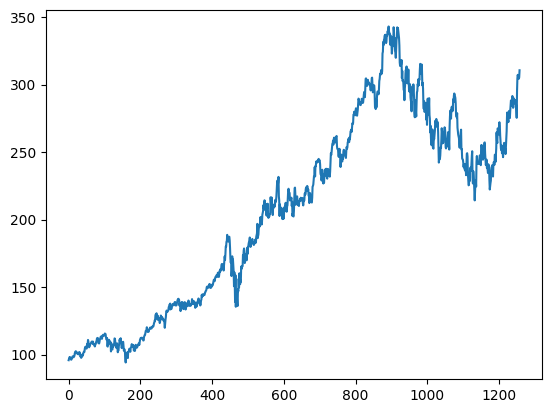

In [300]:
plt.plot(df)

In [301]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1, 1))
df

array([[0.00674753],
       [0.01128605],
       [0.01518194],
       ...,
       [0.84452566],
       [0.84858222],
       [0.86962808]])

In [302]:
training_size = int(len(df) * 0.65)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df), :1]
training_size, test_size

(817, 441)

In [303]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [304]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((716, 100), (716,), (340, 100), (340,))

In [305]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [306]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_19 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [307]:
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 7s 238ms/step - loss: 0.0530 - val_loss: 0.0118
Epoch 2/100
12/12 [==============================] - 2s 150ms/step - loss: 0.0092 - val_loss: 0.0050
Epoch 3/100
12/12 [==============================] - 2s 152ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 4/100
12/12 [==============================] - 2s 149ms/step - loss: 0.0014 - val_loss: 0.0056
Epoch 5/100
12/12 [==============================] - 2s 148ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 6/100
12/12 [==============================] - 2s 148ms/step - loss: 0.0010 - val_loss: 0.0032
Epoch 7/100
12/12 [==============================] - 2s 150ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 8/100
12/12 [==============================] - 2s 148ms/step - loss: 0.0010 - val_loss: 0.0055
Epoch 9/100
12/12 [==============================] - 2s 149ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 10/100
12/12 [==============================] - 2s 149ms/step - loss: 9.6181e-04 - va

In [308]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 34ms/step


In [309]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [310]:
math.sqrt(mean_squared_error(y_train,train_predict))

183.18950762958778

In [311]:
math.sqrt(mean_squared_error(y_test,test_predict))

274.3051456886892

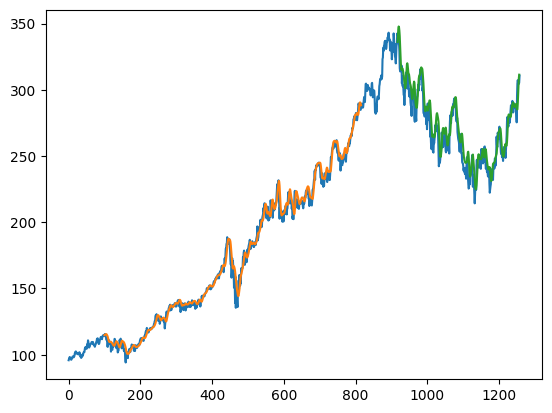

In [312]:
look_back=100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df)-1, :] = test_predict
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [313]:
len(df)

1258

In [314]:
x_input = df[len(df) - 100:].reshape(1, -1)
x_input

array([[0.63611535, 0.65382762, 0.65503253, 0.622058  , 0.60470721,
        0.58767773, 0.59309985, 0.60366294, 0.57860069, 0.58076954,
        0.57366053, 0.56390071, 0.5899269 , 0.5851474 , 0.58418347,
        0.54209173, 0.51482047, 0.5253434 , 0.53413929, 0.54108764,
        0.56888103, 0.57988593, 0.58277773, 0.58727609, 0.56904169,
        0.55345811, 0.58675396, 0.59623263, 0.59406378, 0.58832035,
        0.61800145, 0.61864407, 0.59675476, 0.61723833, 0.63707928,
        0.68467347, 0.65957105, 0.65322516, 0.69656197, 0.69322837,
        0.68073741, 0.67864889, 0.71166359, 0.71507752, 0.70363081,
        0.67483332, 0.6584063 , 0.63675797, 0.63209896, 0.64519238,
        0.62290144, 0.62667684, 0.62370472, 0.6110531 , 0.63049241,
        0.64728091, 0.6536268 , 0.64270223, 0.64089485, 0.63535224,
        0.62037111, 0.64177846, 0.66937103, 0.68804723, 0.73126356,
        0.74423648, 0.7153185 , 0.7215439 , 0.71555948, 0.73712748,
        0.74881517, 0.7319865 , 0.72736766, 0.74

In [315]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6361153506305726,
 0.6538276166760382,
 0.6550325327335529,
 0.622057996626235,
 0.6047072053980238,
 0.5876777251184833,
 0.5930998473772994,
 0.6036629448148445,
 0.5786006908185396,
 0.5807695397220659,
 0.5736605349827295,
 0.5639007149168608,
 0.5899269017591774,
 0.5851474013977025,
 0.5841834685516909,
 0.5420917342758453,
 0.5148204675074303,
 0.5253434010763917,
 0.5341392882962487,
 0.5410876375612498,
 0.5688810346212547,
 0.5798859346132218,
 0.582777733151257,
 0.5872760864326451,
 0.5690416900955899,
 0.553458109085067,
 0.5867539561410554,
 0.5962326291268375,
 0.594063780223311,
 0.5883203470158246,
 0.618001445899269,
 0.6186440677966101,
 0.5967547594184271,
 0.6172383323961763,
 0.6370792834765844,
 0.6846734677484136,
 0.6595710498835248,
 0.6532251586472808,
 0.6965619728492247,
 0.6932283717567675,
 0.6807374086271989,
 0.6786488874608403,
 0.7116635874367419,
 0.7150775162663667,
 0.7036308137199774,
 0.6748333199453769,
 0.6584062976945939,
 0.636757972527913

In [316]:
lst_output=[]
n_steps=100
i=0
while(i<30):
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
    i+=1
lst_output

[[0.8734973073005676],
 [0.8740571737289429],
 [0.8756327033042908],
 [0.8776585459709167],
 [0.879686176776886],
 [0.8815119862556458],
 [0.8831097483634949],
 [0.8845362067222595],
 [0.8858713507652283],
 [0.8871926069259644],
 [0.888562798500061],
 [0.8900336623191833],
 [0.8916454911231995],
 [0.8934295177459717],
 [0.8954101800918579],
 [0.8976033329963684],
 [0.900020182132721],
 [0.9026625752449036],
 [0.9055274724960327],
 [0.9086057543754578],
 [0.9118858575820923],
 [0.915350079536438],
 [0.9189795255661011],
 [0.9227529764175415],
 [0.9266477227210999],
 [0.9306405186653137],
 [0.9347078204154968],
 [0.938825786113739],
 [0.9429726600646973],
 [0.9471288919448853]]

In [317]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [318]:
len(df)

1258

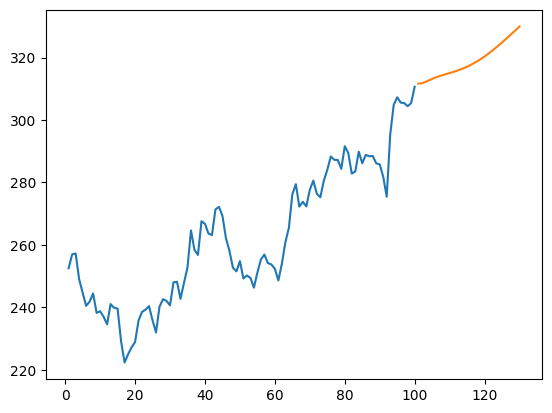

In [319]:
plt.plot(day_new, scaler.inverse_transform(df[1158:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

In [320]:
np.array(lst_output).reshape(1, -1)

array([[0.87349731, 0.87405717, 0.8756327 , 0.87765855, 0.87968618,
        0.88151199, 0.88310975, 0.88453621, 0.88587135, 0.88719261,
        0.8885628 , 0.89003366, 0.89164549, 0.89342952, 0.89541018,
        0.89760333, 0.90002018, 0.90266258, 0.90552747, 0.90860575,
        0.91188586, 0.91535008, 0.91897953, 0.92275298, 0.92664772,
        0.93064052, 0.93470782, 0.93882579, 0.94297266, 0.94712889]])

In [321]:
lst_output

[[0.8734973073005676],
 [0.8740571737289429],
 [0.8756327033042908],
 [0.8776585459709167],
 [0.879686176776886],
 [0.8815119862556458],
 [0.8831097483634949],
 [0.8845362067222595],
 [0.8858713507652283],
 [0.8871926069259644],
 [0.888562798500061],
 [0.8900336623191833],
 [0.8916454911231995],
 [0.8934295177459717],
 [0.8954101800918579],
 [0.8976033329963684],
 [0.900020182132721],
 [0.9026625752449036],
 [0.9055274724960327],
 [0.9086057543754578],
 [0.9118858575820923],
 [0.915350079536438],
 [0.9189795255661011],
 [0.9227529764175415],
 [0.9266477227210999],
 [0.9306405186653137],
 [0.9347078204154968],
 [0.938825786113739],
 [0.9429726600646973],
 [0.9471288919448853]]

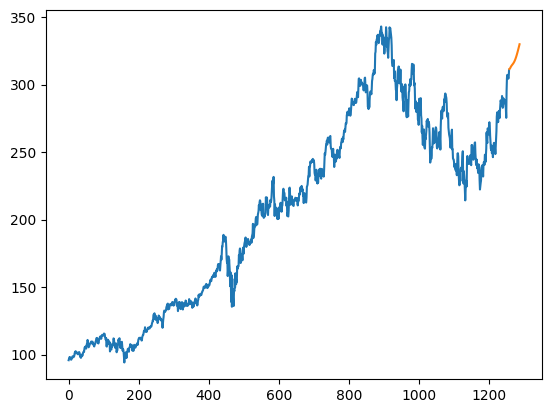

In [322]:
plt.plot(range(len(df)), scaler.inverse_transform(df))
plt.plot(range(len(df), len(df) + 30), scaler.inverse_transform(lst_output))